In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno # pip3 install missingno
import seaborn as sns 
sns.set_style("whitegrid")
%matplotlib inline

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

## 1. Load Data

In [2]:
df=pd.read_csv("sothebys.csv", index_col=0)

In [3]:
#convert datatime columns
df.start_date =pd.to_datetime(df.start_date)
df.end_date =pd.to_datetime(df.end_date)

In [4]:
# Check Auction length
cnt=np.where(df["end_date"]!=df["start_date"],1,0).sum()
#cnt=0
df.drop("end_date",axis=1,inplace=True)

Therefore, we'll use $start\_date$ as the time that the auction occured going forward. 

In [5]:
#clean up birth_year
df.birth_year=pd.to_numeric(df.birth_year,errors='coerce').fillna(0).astype(np.int64)

## 2. Add Features

In [6]:
# Add year, month and season for auction time
df["auc_date"] = pd.DatetimeIndex(df.start_date).normalize()
df['auc_year'] = pd.DatetimeIndex(df['start_date']).year
df['auc_month'] = pd.DatetimeIndex(df['start_date']).month
df['auc_season'] = df["start_date"].apply(lambda dt: (dt.month%12 + 3)//3)

In [7]:
# Add a boolean column to indicate if the lot is named "untitled"
words='|'.join(["INTITULADO","UNTITLED","OHNE TITEL","SANS TITRE","SENZA TITOLO"])
df["is_untitled"]=np.where(df["lot_title"].str.contains(words), 1, 0)
df.is_untitled.value_counts()

0    16574
1     6137
Name: is_untitled, dtype: int64

In [8]:
# Normalize "nth_in_auction" column by "auction_id" into 10 tiles
df["auc_order"]= df.groupby("auction_id")["nth_in_auction"].transform(
                     lambda x: pd.qcut(x, 10, labels=range(1,11))) 

In [9]:
# returns nth_in_auction divided by lot_number = percentage through the auction the lot when lot was shown
lot_order_df = df[['nth_in_auction', 'number_of_lots']].copy()
df['percent_in_auction'] = np.round(lot_order_df.nth_in_auction / lot_order_df.number_of_lots, 3)*100

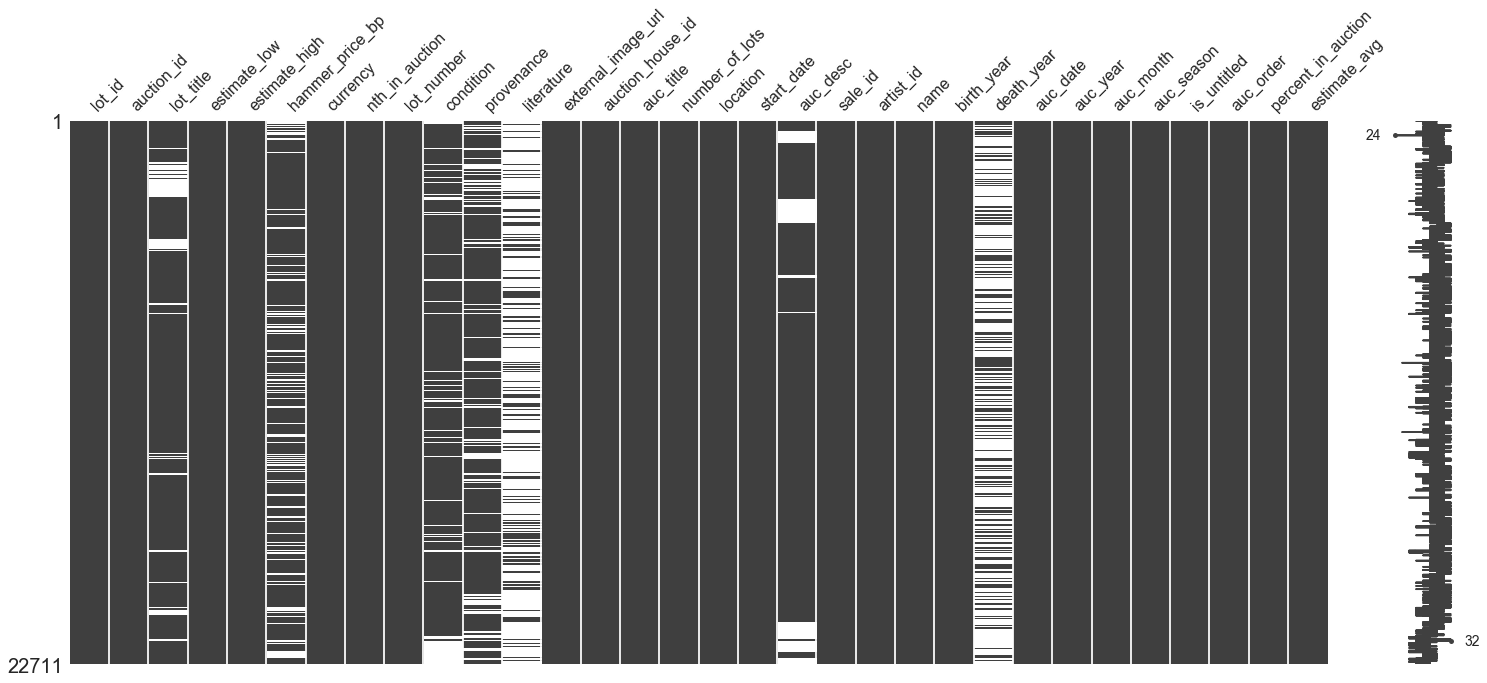

In [10]:
# Add avg_estimate
df["estimate_avg"]=(df["estimate_low"] + df["estimate_high"])/2

msno.matrix(df)

## 3. Convert Currency

In [11]:
# pip install --user currencyconverter
from currency_converter import CurrencyConverter
from datetime import datetime
c = CurrencyConverter(fallback_on_wrong_date=True, fallback_on_missing_rate=True)

hammer_price = df[['hammer_price_bp', 'currency', 'start_date']].copy()
est_low = df[['estimate_low', 'currency', 'start_date']].copy()
est_high = df[['estimate_high', 'currency', 'start_date']].copy()
est_avg = df[['estimate_avg', 'currency', 'start_date']].copy()

hammer_price.start_date = hammer_price.start_date.apply(lambda x: x.strftime('%Y-%m-%d') if not pd.isnull(x) else x)
est_low.start_date = est_low.start_date.apply(lambda x: x.strftime('%Y-%m-%d') if not pd.isnull(x) else x)
est_high.start_date = est_high.start_date.apply(lambda x: x.strftime('%Y-%m-%d') if not pd.isnull(x) else x)
est_avg.start_date = est_avg.start_date.apply(lambda x: x.strftime('%Y-%m-%d') if not pd.isnull(x) else x)

df['hammer_price_bp_usd'] = hammer_price.apply(lambda x: np.round(c.convert(x[0], x[1], 'USD', date=pd.to_datetime(x[2])), 2) if not pd.isnull(x[1]) else x[0], axis=1)
df['estimate_low_usd'] = est_low.apply(lambda x: np.round(c.convert(x[0], x[1], 'USD', date=pd.to_datetime(x[2])), 2) if not pd.isnull(x[1]) else x[0], axis=1)    
df['estimate_high_usd'] = est_high.apply(lambda x: np.round(c.convert(x[0], x[1], 'USD', date=pd.to_datetime(x[2])), 2) if not pd.isnull(x[1]) else x[0], axis=1)
df['estimate_avg_usd'] = est_avg.apply(lambda x: np.round(c.convert(x[0], x[1], 'USD', date=pd.to_datetime(x[2])), 2) if not pd.isnull(x[1]) else x[0], axis=1)

In [12]:
df.sample(20)

,lot_id,auction_id,lot_title,estimate_low,estimate_high,hammer_price_bp,currency,nth_in_auction,lot_number,condition,provenance,literature,external_image_url,auction_house_id,auc_title,number_of_lots,location,start_date,auc_desc,sale_id,artist_id,name,birth_year,death_year,auc_date,auc_year,auc_month,auc_season,is_untitled,auc_order,percent_in_auction,estimate_avg,hammer_price_bp_usd,estimate_low_usd,estimate_high_usd,estimate_avg_usd
19305,10298,31,DINING TABLE STILL LIFE WITH TABLE SETTINGS AN...,18000.0,36000.0,18750.0,GBP,140,201,The board is bowed and stable. There is a milk...,NaN,NaN,http://www.sothebys.com/content/dam/default/un...,1,A Tale of Two Cities: Venice and Dresden,155,LONDON,2015-06-09 09:30:00.592,RESULTS\n\nOur sale A Tale of Two Cities: Veni...,L15320,4041,Galileo Chini,1873,1956,2015-06-09,2015,6,3,0,9,90.3,27000.0,28680.82,27533.59,55067.17,41300.38
11543,8846,115,UNTITLED (23. JAN. 2015),25000.0,35000.0,43750.0,GBP,8,108,Colour:\nThe colours in the catalogue illustra...,Gift from a Private German Collection,CBM is an international development organisati...,http://www.sothebys.com/content/dam/stb/lots/L...,1,Contemporary Art Day Auction,222,LONDON,2016-02-11 12:00:00.478,RESULTS\n\nThe Contemporary Art Day Auction ac...,L16021,133,Gerhard Richter,1932,NaN,2016-02-11,2016,2,1,1,1,3.6,30000.0,63046.89,36026.80,50437.52,43232.16
12147,12009,102,OUR DEAR BICRNACRE 1604,20000.0,30000.0,NaN,USD,22,23,Overall the condition of this work is very goo...,"Read Stremmel Gallery, San Antonio<br>Acquired...",NaN,http://www.sothebys.com/content/dam/default/un...,1,Contemporary Art,334,NEW YORK,2012-09-21 14:00:00.755,OVERVIEW\n\nSotheby’s kicks off the fall seaso...,N08875,948,Grayson Perry,1960,NaN,2012-09-21,2012,9,4,0,1,6.6,25000.0,NaN,20000.00,30000.00,25000.00
12218,15523,117,UNTITLED #6,15000.0,20000.0,34375.0,USD,442,622,This work is in very good condition overall. T...,Private Collection (acquired directly from the...,NaN,http://www.sothebys.com/content/dam/default/un...,1,Contemporary Art Day Auction,450,NEW YORK,2013-05-15 13:30:00.167,OVERVIEW\n\nThe day sale features an impressiv...,N08992,1193,Marilyn Minter,1948,NaN,2013-05-15,2013,5,2,1,10,98.2,17500.0,34375.00,15000.00,20000.00,17500.00
7988,13976,191,"ODALISCASIGNED AND DATED 1930, TERRACOTTA. EXE...",120000.0,180000.0,150750.0,EUR,32,33,This work appears to be in generally good cond...,"Galleria Gian Ferrari, Milano<br>Ivi acquistat...","""Per due anni ho studiato la scultura etrusca ...",http://www.sothebys.com/content/dam/stb/lots/M...,1,Arte Moderna e Contemporanea & Identita’ Itali...,197,MILAN,2011-11-22 17:00:00.247,OVERVIEW\n\nThis autumn the Modern and Contemp...,I0317,4690,Arturo Martini,1889,1947,2011-11-22,2011,11,4,0,1,16.2,150000.0,204040.12,162420.00,243630.00,203025.00
2266,18427,111,SHIPPING OFF THE COAST,400.0,600.0,4250.0,EUR,824,923,Van Deventer: taped to the mount along the upp...,NaN,Offered together with a watercolour by Gerard ...,http://www.sothebys.com/content/dam/stb/lots/A...,1,Property from the Estate of Queen Juliana of T...,1539,AMSTERDAM,2011-03-14 13:00:00.000,OVERVIEW\n\nSotheby's Amsterdam is honoured to...,M1100,7142,"Willem Antonie van DeventerDutch, 1824 - 1893",0,NaN,2011-03-14,2011,3,2,0,6,53.5,500.0,5927.90,557.92,836.88,697.40
1967,18702,111,A MOONLIT WOODED LANDSCAPE,150.0,200.0,1500.0,EUR,1096,1194,Original canvas. No retouches visible under U....,<p>PSD</p>,"brand 1, group no. 1, serial no. 513",http://www.sothebys.com/content/dam/stb/lots/A...,1,Property from the Estate of Queen Juliana of T...,1539,AMSTERDAM,2011-03-14 13:00:00.000,OVERVIEW\n\nSotheby's Amsterdam is honoured to...,M1100,7396,"Daniël J. R. Jordens, Dutch, 1855 - 1939",0,NaN,2011-03-14,2011,3,2,0,8,71.2,175.0,2092.20,209.22,278.96,244.09
1527,19157,202,FRINGED SUN,25000.0,35000.0,31250.0,USD,3,4,This work is in very good condition overall. ...,"Perls Galleries, New York<br>Acquired by the p...",NaN,http://www.sothebys.com/content/dam/default

## 4. Export to CSV

In [13]:
df.to_csv("final_sothebys.csv")